# DAY 4: Classification - models and evaluation

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: July 27th, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________


## Learning Goals:

1. train logistic regression with linear and polynomial boundaries
2. understand the problem of class imbalance in classification
3. identify the appropriate evaluation metrics for real-life problems
4. compute the accuracy and confusion matrix

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

#import data processing
from sklearn.model_selection import train_test_split

#import models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest

#import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

#import visualization libraries
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Auxiliary functions to generate and visualize data. 
**No need to read through!**

In [2]:
def make_toy_data():
    '''
    make_toy_data generates synthetic data for the cancer classification task.
    
    input: None
    returns: 
       x_train - an numpy array of size 737 x 2, each row is a patient, each column is a biomarker
       x_test - an numpy array of size 363 x 2, each row is a patient, each column is a biomarker
       y_train - an numpy array of length 737, each entry is either 0 (no cancer) or 1 (cancerous)
       y_test - an numpy array of length 363, each entry is either 0 (no cancer) or 1 (cancerous)
    '''
    
    class_0_size = 1000
    mu_0 = np.array([10, 15])
    Sigma_0 = np.array([[50, -30], 
                        [-30, 80]])
    class_0 = np.random.multivariate_normal(mu_0, Sigma_0, size=class_0_size)

    class_1_size = 100
    mu_1 = np.array([22, 6])
    Sigma_1 = np.array([[20, 5], 
                        [5, 20]])
    class_1 = np.random.multivariate_normal(mu_1, Sigma_1, size=class_1_size)
    
    x = np.vstack((class_0, class_1))
    y = np.hstack((np.zeros(class_0_size), np.ones(class_1_size)))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return x_train, x_test, y_train, y_test

def scatter_plot_data(x, y, ax):
    '''
    scatter_plot_data scatter plots the patient data. A point in the plot is colored 'red' if cancerous 
    and blue otherwise.
    
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       ax - axis to plot on
    returns: 
       ax - the axis with the scatter plot
    '''
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.set_xlim((-20, 40))
    ax.set_ylim((-20, 40))
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    ax.legend(loc='best')
    return ax

def plot_decision_boundary(x, y, model, ax=None, plot_boundary_only=False, poly_degree=1):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a location, each column is a coordinate
       y - a numpy array of length N, each entry is either 0 (non-vegetation) or 1 (vegetation)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    if ax is None: f, ax = plt.subplots()

    # Plot data
    if not plot_boundary_only:
        ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='cancer')
        ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='healthy')
    
    # Create mesh
    interval = np.arange(-20,40,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if not plot_boundary_only:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    ax.contour(x1, x2, yy, colors='black', linewidths=0.1)
    ax.set_xlim([-20, 40])
    ax.set_ylim([-20, 40])
    ax.set_xlabel('Marker 1')
    ax.set_ylabel('Marker 2')
    ax.legend(loc='best')
    return ax

## Introduction: Cancer Diagnosis Based on Biopsy Markers

In this problem, we want to classify whether or not a patient has a rare and aggressive type of skin cancer based on two biomarkers extracted from biopsies of skin samples.

In the lectures, we have seen that:
1. ***accuracy*** is a bad metric (even terribles models can have 100% accuracy simply due to class imbalance).

2. visualizing the ***decision boundary*** of a classifier is a better way to evaluate model performance, but it is not possible to visualize most real-datasets (due to the large number of features).

2. the ***confusion matrix*** is a better way to assess the performance of classifiers, but we still prefer a single number to summarize aspects of the matrix that we care about.

**Instructions**: run the code below to make a toy training and testing classification data set and visualize the data.

We generate toy data for this application. `x` is a an array where each row represents a patient and each column represents a biomarker. `y` is an array of `0`'s and `1`'s, where `0` indicates absence of cancer and `1` indicates presence of cancer.

In [3]:
# generate toy data
x_train, x_test, y_train, y_test = make_toy_data()

print('Number of patients:', x_train.shape[0])
print('Number of features:', x_train.shape[1])

Number of patients: 737
Number of features: 2


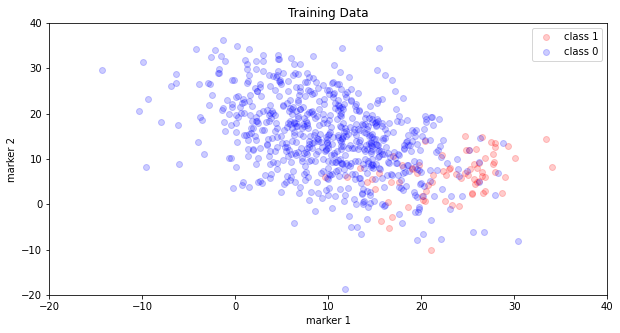

In [4]:
# visualize the toy data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
scatter_plot_data(x_train, y_train, ax)
ax.set_title('Training Data')
plt.show()

## 1. Logistic regression

We first fit a logistic regression model to this dataset using a **linear** decision boundary and evaluate its performance.

**Exercise 1:** Use `sklearn`'s `LogisticRegression` model to fit a logistic regression classifier and plot its decision boundary using `plot_decision_boundary`.

<AxesSubplot:xlabel='Marker 1', ylabel='Marker 2'>

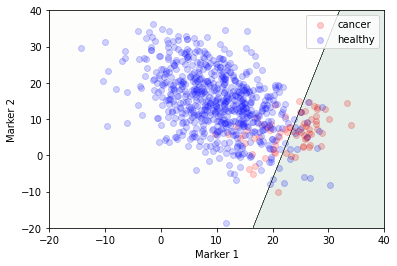

In [5]:
# Fit a logistic regression classifier
# and plot decision boundary
#
# Hint: you may want to look at this for reference about sklearn's logistic regression classifier: 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# COMPLETE
# Step 1: Instantiate a sklearn LogisticRegression model
logistic = LogisticRegression()
# 
# Step 2: Fit the model to our training dataset
logistic.fit(x_train, y_train)

# Step 3: Plot the decision boundary using the `plot_decision_boundary` function
plot_decision_boundary(x_train, y_train, logistic)

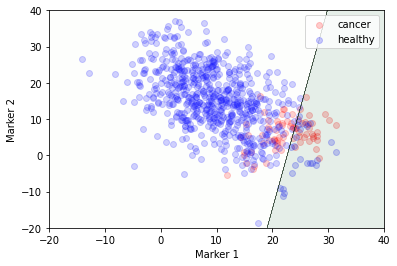

In [ ]:
# SOLUTION
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(x_train, y_train)

plot_decision_boundary(x_train, y_train, logistic);

**Exercise 2:** Use your model's `.score()` function to compute the overall accuracy of your classifier. Then, use `sklearn`'s `plot_confusion_matrix` to visualize the confusion matrix of our logistic regression classifier.

In [6]:
# Step 1: compute the accuracy of your classifer using the .score() function
# Hint:  you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score
#
test_accuracy = logistic.score(x_test, y_test)
train_accuracy = logistic.score(x_train, y_train)
print('The train accuracy is: {}, The test accuracy is: {}'.format(train_accuracy, test_accuracy))

The train accuracy is: 0.9280868385345997, The test accuracy is: 0.9228650137741047


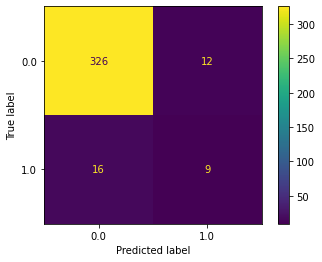

In [8]:
# Step 2: plot confusion matrix
#
# Hint: you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
#
# COMPLETE
plot_confusion_matrix(logistic, x_test, y_test)

**Exercise 3:** Interpret the parameters of this model, which biomarker (marker 1 or 2) has a bigger impact on the probability of being classified as positive for cancer?

In [9]:
# Step 1: print out the parameters of your logistic regression model using the .coef_ attribute of your model
# Hint:  you may want to look for a description of the .coef_ attribute here
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# COMPLETE
print(logistic.coef_)

[[ 0.3143372  -0.08132202]]


**Exercise 4:** Is this a good classifier for our data set? Why or why not? Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual patients.

**Exercise 5:** Instead of classifying rare diseases, imagine that this classifier is being used to detect if students are cheating on an exam, with class 0 representing students who did not cheat and class 1 representing students who cheated. If a student is predicted by this model to have cheated then he or she may be expelled. 

Discuss whether or nor the above classifier is appropriate for this cheating application. Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual students.


## 2. Logistic regression with polynomial boundary

We now fit a logistic regression model to this dataset using a **polynomial** decision boundary and evaluate its performance.

**Exercise 6:** Use `sklearn`'s `LogisticRegression` model to fit a logistic regression classifier and plot its decision boundary using `plot_decision_boundary`. What is the best degree for the polynomial decision boundary? Why?

C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:xlabel='Marker 1', ylabel='Marker 2'>

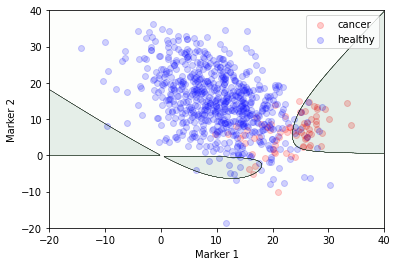

In [33]:
# Step 1: transform your training and testing data into polynomial features
# using sklearn's PolynomialFeatures
degree_of_polynomial = 5 # we first try a 10 degree polynomial
polynomial_features = PolynomialFeatures(degree_of_polynomial) # instantiate PolynomialFeatures
polynomial_features.fit(x_train) # fit on our training iput
x_train_poly = polynomial_features.transform(x_train) # add polynomial powers to our training input 
x_test_poly = polynomial_features.transform(x_test)# add polynomial powers to our test input

# Step 2: instantiate a LogisticRegression model
# COMPLETE
logistic_poly = LogisticRegression(fit_intercept=False, solver='lbfgs')

# Step 3: fit this model to our training data
# COMPLETE
logistic_poly.fit(x_train_poly, y_train)
#
# Step 4: plot the decision boundary of this model
plot_decision_boundary(x_train, y_train, logistic_poly, poly_degree=degree_of_polynomial)

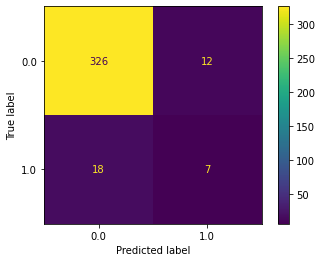

In [31]:
# Step 5: plot confusion matrix
#
# Hint: you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
#
# COMPLETE
plot_confusion_matrix(logistic_poly, x_test_poly, y_test)

**Exercise 7:** If you printed out the parameters of this logistic regression model with polynomial decision boundary, would you be able to conclude which covariate (marker 1 or 2) has a bigger impact on the chances of being classified with cancer (class 1)?

**Exercise 8:** Is this a good classifier for our data set? Why or why not? Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual patients.